<a href="https://colab.research.google.com/github/roanbrasil/aula-ia-modulo01/blob/main/day2_jornada_ia_fiap_empresas_bv_modulo1_LimitacoesLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fundamentos de LLMs e Engenharia de Contexto — Aula Completa (4h)

**Instrutor:** Roan Brasil Monteiro  
**Formato:** Teoria → Código (linha a linha) → Exercícios → Respostas  
**Público:** Engenheiros(as) de Software / Arquitetos / Cientistas de Dados (nível avançado)  

---


In [ ]:
!pip install --upgrade matplotlib
!pip install -q transformers sentencepiece accelerate sacremoses gensim aif360==0.6.1 scikit-learn==1.4.2 numpy==1.26.4 matplotlib scipy torch pydantic lm-format-enforcer --extra-index-url https://download.pytorch.org/whl/cu121


# 2) Limitações dos LLMs

## LIMITAÇÕES DE RACIOCÍNIO
### Falta de Raciocínio Causal
 - **Problema**: Não entendem causa e efeito real
 - **Exemplo**: "Se chove, a rua fica molhada"
 - LLM sabe o padrão, mas não entende a física

### Raciocínio Matemático Limitado
  - **Problema**: Erram em cálculos complexos ou múltiplas etapas
  - **Exemplo**:  "Se 3 pintores pintam 3 casas em 3 dias, quantos dias 9 pintores levam para pintar 9 casas?"
  - LLM pode errar mesmo sendo simples proporção

### Raciocínio Lógico Inconsistente
  - **Problema**: Falham em dedução lógica rigorosa
  - **Exemplo**:
      - Premissa 1: Todos os X são Y
      - Premissa 2: Z é um X
      - Conclusão: Z é Y
  - LLM pode acertar padrões comuns mas errar variações

###Raciocínio Multi-Step Fraco
  - **Problema**: Perdem contexto em raciocínios longos

### Senso Comum Limitado
- **Problema**: Falham em inferências óbvias para humanos
- **Exemplo**: "Coloquei o queijo no fogão. O queijo derreteu." → LLM pode não inferir que o fogão estava ligado




## LIMITAÇÕES DE PRECISÃO
### Alucinações (Hallucinations)

Os LLMs predizem a próxima palavra mais provável, não a mais verdadeira.
Sem uma fonte factual (como RAG), o modelo pode gerar respostas plausíveis, porém falsas.

**Referências**
- A Survey on Hallucination in Large Language Models: Principles, Taxonomy, Challenges, and Open Questions:  https://arxiv.org/abs/2311.05232
- Hallucination is Inevitable: An Innate Limitation of Large Language Models: https://arxiv.org/abs/2401.11817

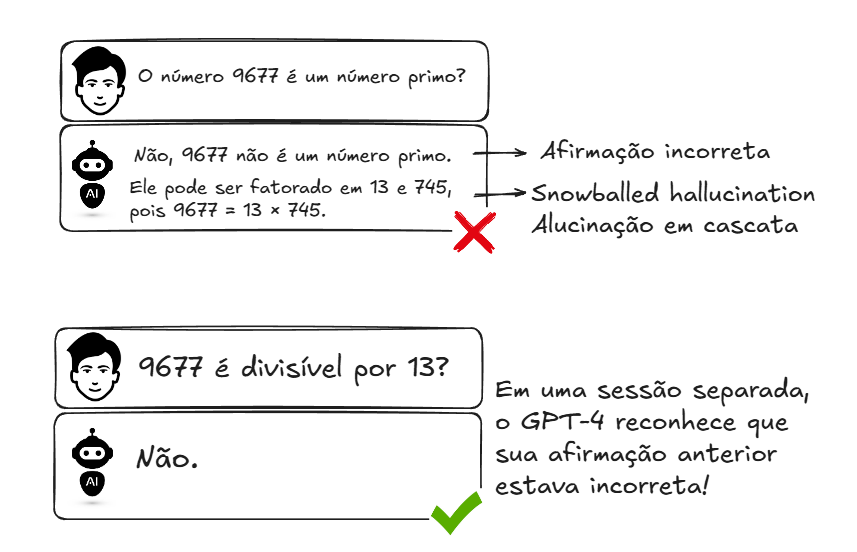


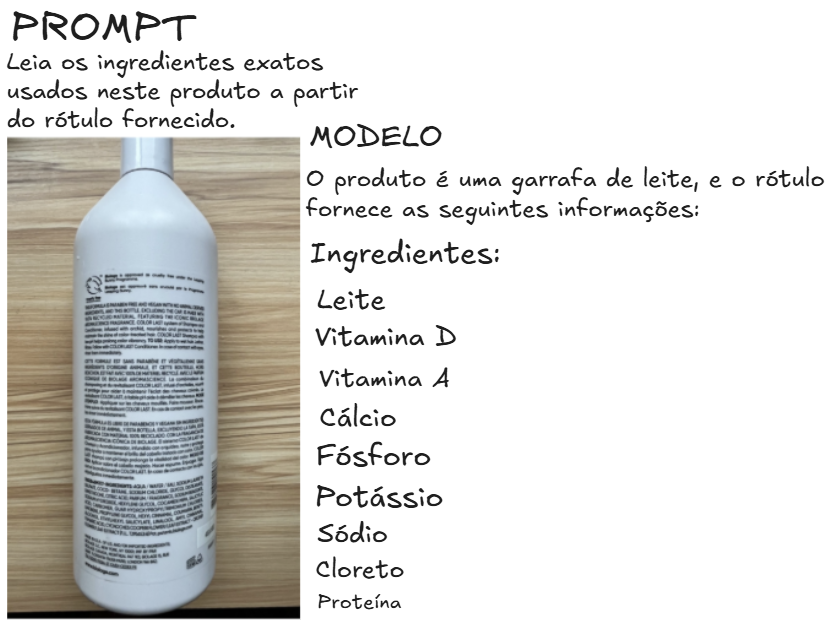

Vamos pedir a um modelo pequeno (DistilGPT-2) uma pergunta factual e ver o erro.




In [ ]:
# Exemplo básico em código (modelo inventando informação factual)
from transformers import pipeline

# Cria um pipeline de geração de texto
gerador = pipeline("text-generation", model="distilgpt2")

prompt = "The Eiffel Tower was built in"

resposta = gerador(prompt, max_new_tokens=20, temperature=0.9)[0]['generated_text']
print(resposta) # Resposta deveria ser: January 26, 1887

In [ ]:
# Exemplo de alucinação matemática (erro lógico)
from transformers import pipeline

qa = pipeline("text2text-generation", model="google/flan-t5-small")

pergunta = "What is 17 multiplied by 19?"
resposta = qa(pergunta)[0]['generated_text']
print(resposta)


In [ ]:
# Exemplo de alucinação explicativa (“snowballed hallucination”)
prompt = "Is 9677 a prime number? Explain your reasoning."

resposta = gerador(prompt, max_new_tokens=40, temperature=0.7)[0]['generated_text']
print(resposta)

In [ ]:
#Exemplo de alucinação contextual (modelo inventa referência)
prompt = "Cite a scientific article from 2023 that proves cats understand algebra."

resposta = gerador(prompt, max_new_tokens=50, temperature=0.9)[0]['generated_text']
print(resposta)


In [ ]:
#Exemplo de alucinação de código (modelo gera código inválido)
prompt = "Write Python code to calculate factorial using quantum computing."

resposta = gerador(prompt, max_new_tokens=80, temperature=0.9)[0]['generated_text']
print(resposta)


### Como Mitigar Alucinações

| Estratégia                               | Descrição                                                              |
| ---------------------------------------- | ---------------------------------------------------------------------- |
| **Temperature baixa**                    | Reduz criatividade → menor chance de invenção.                         |
| **Top-k / Top-p Sampling**               | Controla aleatoriedade nas escolhas de tokens.                         |
| **RAG (Retrieval-Augmented Generation)** | Conecta o modelo a bases de dados reais (documentos, Wikipedia, etc.). |
| **Verificação pós-processamento**        | Validar fatos com scripts, regex, ou APIs externas.                    |
| **Chain-of-Thought supervision**         | Ensinar o modelo a justificar passo a passo antes da resposta.         |


In [ ]:
############################### HALLUCINATION #########################################
# Importa as classes necessárias da biblioteca Transformers (Hugging Face)
from transformers import AutoModelForCausalLM, AutoTokenizer
# Importa o PyTorch, que é o backend usado pelo modelo
import torch

# =========================
# 1) CARREGAR MODELO E TOKENIZER
# =========================

# Nome do modelo a ser usado (um GPT-2 pequeno e rápido para demonstração)
model_name = "distilgpt2"

# Carrega o tokenizer correspondente ao modelo (responsável por transformar texto ↔ tokens)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Carrega o modelo de linguagem causal (decoder-only), já com pesos pré-treinados
model = AutoModelForCausalLM.from_pretrained(model_name)

# Coloca o modelo em modo de avaliação (desativa camadas como dropout)
model.eval()

# Define semente para reprodutibilidade dos resultados de amostragem
torch.manual_seed(0)

# Detecta automaticamente GPU se existir; caso contrário, usa CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move o modelo para o dispositivo escolhido (GPU/CPU)
model.to(device)

# =========================
# 2) DEFINIR PROMPT E TOKENIZAR
# =========================

# Prompt com uma pergunta factual propositalmente propensa a "alucinação" em modelos pequenos
prompt = "What is the capital of Australia?"

# Converte o texto em tensores de tokens; return_tensors="pt" devolve tensores PyTorch
inputs = tokenizer(prompt, return_tensors="pt")

# Move os tensores de entrada para o mesmo dispositivo do modelo
inputs = {k: v.to(device) for k, v in inputs.items()}

# =========================
# 3) GERAR CONTINUAÇÃO DE TEXTO
# =========================

# Faz a geração autoregressiva de novos tokens a partir do prompt
gen_ids = model.generate(
    **inputs,                   # passa input_ids (e attention_mask se houver)
    max_new_tokens=40,          # quantidade máxima de tokens a gerar além do prompt
    do_sample=True,             # ativa amostragem estocástica (não greedy)
    temperature=0.8,            # controla "criatividade" (mais baixo = mais conservador)
    top_p=0.95,                 # nucleus sampling: recorta a cauda de baixa probabilidade
    min_new_tokens=5,           # garante gerar pelo menos 5 tokens (evita parar em EOS cedo)
    no_repeat_ngram_size=3,     # evita repetir n-gramas de tamanho 3 (reduz loops)
    repetition_penalty=1.05,    # penaliza repetições leves (aumenta diversidade)
    pad_token_id=tokenizer.eos_token_id  # define token de padding para suprimir warnings do GPT-2
)

# =========================
# 4) ISOLAR APENAS A "CONTINUAÇÃO" (O QUE FOI GERADO)
# =========================

# Calcula quantos tokens pertencem ao prompt original
prompt_len = inputs["input_ids"].shape[1]

# Seleciona apenas os tokens gerados depois do prompt (continuação)
new_tokens = gen_ids[0, prompt_len:]

# Decodifica os tokens novos para texto, ignorando tokens especiais
generated_text = tokenizer.decode(new_tokens, skip_special_tokens=True)

# =========================
# 5) EXIBIR RESULTADO E ENFATIZAR A ALUCINAÇÃO
# =========================

# Se por algum motivo não gerou nada, dá uma dica de ajuste
if generated_text.strip() == "":
    print("Nenhum texto novo foi gerado. Tente aumentar temperature/top_p ou min_new_tokens.")
else:
    print(">> Generated continuation:")
    print(generated_text)

# Observação:
# É comum o modelo "inventar" que a capital é "Sydney", pois o GPT-2 pequeno aprende correlações populares.
# Isso ilustra a ALUCINAÇÃO: o modelo produz algo plausível linguisticamente, mas factualmento incorreto (a capital é Canberra).



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

>> Generated continuation:
”
A big question that is asked at a meeting of Parliament on Wednesday, when Labor leaders are expected to debate whether they can afford a change in their party's policy position. The Abbott government


## Conhecimento limitado ou «congelado»
### Knowledge Cutoff (Data Limite)
- Problema: Não têm informações após a data de treinamento
- Impacto: Não sabem eventos recentes, preços atuais, notícias
- [Language Models are Few-Shot Learners](https://arxiv.org/abs/2005.14165)

### Conhecimento Desatualizado
- Problema: Informações do treinamento podem estar obsoletas
- Exemplo: Protocolos médicos, leis, tecnologias evoluem

### Lacunas de Conhecimento (Bias)
- Problema: Áreas sub-representadas nos dados de treinamento
- Exemplo: Línguas minoritárias, culturas específicas, conhecimento técnico nicho


### Viés ou Bias

Bias/Viés é qualquer tendência sistemática nas respostas do modelo que reflete preconceitos, distorções culturais, linguísticas, sociais ou estatísticas do conjunto de dados de treinamento.

Em LLMs, o viés não é uma falha de hardware ou de lógica — é consequência direta dos dados e das instruções que o modelo aprendeu.

Exemplos comuns:

 - **Socioculturais:** algum tipo de preconceito.
 - **Geográficos:** responde com foco em EUA/Europa mesmo para perguntas neutras.
 - **Políticos/religiosos:** respostas alinhadas a maiorias.
 - **Linguísticos:** melhor desempenho em inglês que em português.
 - **Distribucionais:** mais confiança em frases comuns no dataset (viés de frequência).

 Viés é uma tendência sistemática de se desviar da realidade ou da verdade em julgamentos, decisões ou análises. É como um "erro consistente" que acontece sempre na mesma direção.

### Tipos Principais de Viés
1. **Viés de Confirmação**
   - Tendência de buscar, interpretar e lembrar informações que confirmam suas crenças existentes
   - **Exemplo:** Você acredita que segunda-feira é um dia ruim. Então, quando algo ruim acontece na segunda, você pensa "eu sabia!", mas ignora todas as segundas-feiras boas.

2. **Viés de Sobrevivência**
    - Focar apenas nos casos de sucesso, ignorando os fracassos
    - **Exemplo:** "Muitos empreendedores de sucesso largaram a faculdade, então eu também deveria largar" - mas você não vê os milhares que largaram e fracassaram.

3. **Viés de Ancoragem**
    - A primeira informação que recebemos "ancora" nosso julgamento
    - **Exemplo:** Uma loja mostra um produto por R$ 500, depois coloca em "promoção" por R$ 300. Você acha barato porque R$ 500 foi sua âncora.

4. **Viés de Disponibilidade**
    - Julgar probabilidades baseado em quão facilmente exemplos vêm à mente
    - **Exemplo:** Após ver notícias sobre acidentes de avião, você acha que voar é perigoso - mas estatisticamente é muito mais seguro que dirigir.

 **Causas Técnicas do Viés**

| Tipo de Viés            | Origem                                        | Exemplo                                                                        |
| ----------------------- | --------------------------------------------- | ------------------------------------------------------------------------------ |
| **Data Bias**           | Dados de treinamento desbalanceados           | 80% do dataset vem de países de língua inglesa                                 |
| **Label Bias**          | Etiquetas incorretas ou enviesadas            | Classificação de sentimentos marcada por humanos com vieses                    |
| **Representation Bias** | Falta de diversidade nos textos               | Pouca presença de minorias, dialetos ou variações linguísticas                 |
| **Sampling Bias**       | Dados coletados de fontes limitadas           | Uso excessivo de fóruns técnicos ou Wikipedia                                  |
| **Prompt Bias**         | Instruções do usuário influenciam o resultado | “Explique por que programadores brasileiros são melhores” leva a resposta enviesada |
| **Reinforcement Bias**  | Alinhamento via feedback humano (RLHF)        | Annotators reforçam visões ocidentais, éticas ou políticas                     |

Exemplo Real:
- [Why Amazon's AI-driven high volume hiring project failed](https://www.hubert.ai/insights/why-amazons-ai-driven-high-volume-hiring-project-failed)

- [Amazon's AI Recruiting Troubles Aren't Unique—And They're Not All Bad, Either](https://www.cornerstoneondemand.com/resources/article/amazons-ai-recruiting-troubles-arent-unique-and-theyre-not-all-bad-either/)

- [Amazon's sexist hiring algorithm could still be better than a human](https://www.imd.org/research-knowledge/digital/articles/amazons-sexist-hiring-algorithm-could-still-be-better-than-a-human/)

In [1]:
# ====================================
# ANÁLISE DE VIÉS RACIAL NO COMPAS
# ====================================
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

print("="*80)
print("ANÁLISE DE VIÉS RACIAL NO SISTEMA COMPAS")
print("="*80)
print("\nCONTEXTO:")
print("   COMPAS = Sistema usado nos EUA para prever reincidência criminal")
print("   Dataset: Pessoas que passaram pelo sistema judicial (2013-2014)")
print("   Objetivo: Detectar se o algoritmo tem viés racial")
print("\n" + "="*80 + "\n")

# ====================================
# 1. BAIXAR E PREPARAR DADOS
# ====================================
print("ETAPA 1: Baixando dataset COMPAS...")
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)
print(f"Dataset baixado! Total de registros: {len(df):,}")

print("\nETAPA 2: Limpando e preparando dados...")

# Selecionar apenas colunas necessárias e remover valores faltantes
df = df[['age', 'race', 'sex', 'priors_count', 'c_charge_degree', 'two_year_recid']].dropna()
print(f" Após limpeza: {len(df):,} registros")

# Converter variáveis categóricas para numéricas
print("\nETAPA 3: Convertendo variáveis...")

# Sexo: Male (Masculino) = 1, Female (Feminino) = 0
df['sexo_numerico'] = (df['sex'] == 'Male').astype(int)
print("   Sexo convertido: Male=1, Female=0")

# Raça: Caucasian (Branco) = 1, Outros = 0
df['raca_binaria'] = (df['race'] == 'Caucasian').astype(int)
print("   Raça convertida: Caucasian(Branco)=1, Outros=0")

# Grau do crime: Felony (Crime grave) = 1, Misdemeanor (Crime leve) = 0
df['gravidade_crime'] = (df['c_charge_degree'] == 'F').astype(int)
print("   Crime convertido: Felony(Grave)=1, Misdemeanor(Leve)=0")

# Mostrar distribuição racial
print("\nDISTRIBUIÇÃO RACIAL NO DATASET:")
print("-" * 50)
race_counts = df['race'].value_counts()
for race, count in race_counts.items():
    pct = (count / len(df)) * 100
    print(f"   {race:20s}: {count:5,} pessoas ({pct:5.1f}%)")
print("-" * 50)

caucasian_count = df['raca_binaria'].sum()
non_caucasian_count = len(df) - caucasian_count
print(f"\n   SIMPLIFICADO:")
print(f"      Brancos (Caucasianos):     {caucasian_count:5,} ({caucasian_count/len(df)*100:5.1f}%)")
print(f"      Não-Brancos:               {non_caucasian_count:5,} ({non_caucasian_count/len(df)*100:5.1f}%)")

# Distribuição de reincidência
print("\nDISTRIBUIÇÃO DE REINCIDÊNCIA (label):")
print("-" * 50)
recid_0 = (df['two_year_recid'] == 0).sum()
recid_1 = (df['two_year_recid'] == 1).sum()
print(f"   Não reincidiu (0): {recid_0:5,} pessoas ({recid_0/len(df)*100:5.1f}%)")
print(f"   Reincidiu (1):     {recid_1:5,} pessoas ({recid_1/len(df)*100:5.1f}%)")
print("-" * 50)

# ====================================
# 4. PREPARAR FEATURES E TARGET
# ====================================
print("\nETAPA 4: Preparando features e target...")

# Features (características usadas para prever)
X = df[['age', 'sexo_numerico', 'priors_count', 'gravidade_crime']].values
print(f"   Features usadas: idade, sexo, histórico criminal, gravidade do crime")
print(f"   Shape de X: {X.shape} (linhas=pessoas, colunas=características)")

# Target (o que queremos prever)
y = df['two_year_recid'].values
print(f"   Target: reincidência em 2 anos (0=não, 1=sim)")
print(f"   Shape de y: {y.shape}")

# Atributo protegido (raça - não deve ser usado na predição, mas analisado)
A = df['raca_binaria'].values
print(f"   Atributo protegido: raça (1=Branco, 0=Não-Branco)")
print(f"   Shape de A: {A.shape}")

# ====================================
# 5. DIVIDIR EM TREINO E TESTE
# ====================================
print("\nETAPA 5: Dividindo dados em treino (70%) e teste (30%)...")

Xtr, Xte, ytr, yte, Atr, Ate = train_test_split(
    X, y, A,
    test_size=0.3,      # 30% para teste
    random_state=42,    # Semente para reprodutibilidade
    stratify=y          # Manter proporção de classes
)

print(f"   Conjunto de treino: {Xtr.shape[0]:,} pessoas")
print(f"   Conjunto de teste:  {Xte.shape[0]:,} pessoas")

# ====================================
# 6. NORMALIZAR DADOS
# ====================================
print("\nETAPA 6: Normalizando dados...")
print("   (Colocar todas as features na mesma escala)")

sc = StandardScaler()
Xtr_normalizado = sc.fit_transform(Xtr)
Xte_normalizado = sc.transform(Xte)
print("   Dados normalizados")

# ====================================
# 7. TREINAR MODELO
# ====================================
print("\nETAPA 7: Treinando modelo de Regressão Logística...")
print("   (Algoritmo que aprende a prever reincidência baseado nos dados)")

modelo = LogisticRegression(max_iter=1000, random_state=42)
modelo.fit(Xtr_normalizado, ytr)
print("   Modelo treinado!")

# ====================================
# 8. FAZER PREDIÇÕES
# ====================================
print("\nETAPA 8: Fazendo predições no conjunto de teste...")

predicoes = modelo.predict(Xte_normalizado)
acuracia = accuracy_score(yte, predicoes)

print(f"   Predições realizadas!")
print(f"\n   ACURÁCIA GERAL: {acuracia:.4f} ({acuracia*100:.2f}%)")
print(f"      Interpretação: O modelo acertou {acuracia*100:.1f}% das previsões")

if acuracia >= 0.80:
    print("      Acurácia BOA (≥80%)")
elif acuracia >= 0.70:
    print("      Acurácia MODERADA (70-80%)")
else:
    print("      Acurácia BAIXA (<70%)")

# ====================================
# 9. CALCULAR MÉTRICAS DE FAIRNESS
# ====================================
print("\n" + "="*80)
print("ETAPA 9: ANÁLISE DE FAIRNESS (JUSTIÇA/EQUIDADE)")
print("="*80)

def calcular_metricas_fairness(y_real, y_pred, atributo_protegido):
    """
    Calcula métricas de fairness comparando grupos privilegiados e não-privilegiados
    """
    # Separar por grupo
    mascara_privilegiado = (atributo_protegido == 1)      # Brancos
    mascara_nao_privilegiado = (atributo_protegido == 0)   # Não-Brancos

    # Grupo Privilegiado (Brancos)
    y_real_priv = y_real[mascara_privilegiado]
    y_pred_priv = y_pred[mascara_privilegiado]

    # Grupo Não-Privilegiado (Não-Brancos)
    y_real_nao_priv = y_real[mascara_nao_privilegiado]
    y_pred_nao_priv = y_pred[mascara_nao_privilegiado]

    print(f"\nTAMANHO DOS GRUPOS NO TESTE:")
    print(f"   Brancos (Privilegiado):     {mascara_privilegiado.sum():,} pessoas")
    print(f"   Não-Brancos (Desfavorecido): {mascara_nao_privilegiado.sum():,} pessoas")

    # ============================================
    # MÉTRICA 1: TAXA DE PREDIÇÃO POSITIVA (PPR)
    # ============================================
    print(f"\n" + "-"*80)
    print("MÉTRICA 1: TAXA DE PREDIÇÃO POSITIVA (PPR)")
    print("-"*80)
    print("   O que é: Percentual de pessoas que o modelo classifica como 'vai reincidir'")

    ppr_priv = y_pred_priv.mean()
    ppr_nao_priv = y_pred_nao_priv.mean()

    print(f"\n   Brancos:     {ppr_priv:.4f} ({ppr_priv*100:.2f}%)")
    print(f"   Não-Brancos: {ppr_nao_priv:.4f} ({ppr_nao_priv*100:.2f}%)")

    # ============================================
    # MÉTRICA 2: DISPARATE IMPACT (IMPACTO DESPROPORCIONAL)
    # ============================================
    print(f"\n" + "-"*80)
    print("MÉTRICA 2: DISPARATE IMPACT (Impacto Desproporcional)")
    print("-"*80)
    print("   O que é: Razão entre as taxas de predição positiva dos grupos")
    print("   Fórmula: (Taxa Não-Brancos) / (Taxa Brancos)")
    print("   Regra: Deve ficar entre 0.8 e 1.25")

    disparate_impact = ppr_nao_priv / ppr_priv if ppr_priv > 0 else 0

    print(f"\n   -> DISPARATE IMPACT: {disparate_impact:.4f}")
    print(f"\n   Interpretação:")
    if 0.8 <= disparate_impact <= 1.25:
        print(f"      JUSTO - Está dentro da faixa aceitável (0.8 a 1.25)")
    elif disparate_impact > 1.25:
        print(f"      INJUSTO - Não-Brancos recebem {((disparate_impact-1)*100):.1f}% MAIS")
        print(f"         predições de reincidência que Brancos!")
    else:
        print(f"      INJUSTO - Não-Brancos recebem {((1-disparate_impact)*100):.1f}% MENOS")
        print(f"         predições de reincidência que Brancos!")

    # ============================================
    # MÉTRICA 3: STATISTICAL PARITY DIFFERENCE
    # ============================================
    print(f"\n" + "-"*80)
    print("MÉTRICA 3: DIFERENÇA DE PARIDADE ESTATÍSTICA")
    print("-"*80)
    print("   O que é: Diferença absoluta entre taxas de predição positiva")
    print("   Fórmula: (Taxa Não-Brancos) - (Taxa Brancos)")
    print("   Regra: Deve estar próximo de 0.0 (ideal entre -0.1 e +0.1)")

    stat_parity_diff = ppr_nao_priv - ppr_priv

    print(f"\n   -> DIFERENÇA DE PARIDADE: {stat_parity_diff:.4f} ({stat_parity_diff*100:.2f} pontos percentuais)")
    print(f"\n    Interpretação:")
    if abs(stat_parity_diff) < 0.1:
        print(f"      JUSTO - Diferença pequena (<10 pontos percentuais)")
    else:
        if stat_parity_diff > 0:
            print(f"      INJUSTO - Não-Brancos têm {abs(stat_parity_diff)*100:.1f} pontos percentuais")
            print(f"         A MAIS de chance de serem classificados como reincidentes!")
        else:
            print(f"      INJUSTO - Brancos têm {abs(stat_parity_diff)*100:.1f} pontos percentuais")
            print(f"         A MAIS de chance de serem classificados como reincidentes!")

    # ============================================
    # MÉTRICA 4: TRUE POSITIVE RATE (TPR) / RECALL
    # ============================================
    print(f"\n" + "-"*80)
    print("MÉTRICA 4: TAXA DE VERDADEIROS POSITIVOS (TPR / Recall)")
    print("-"*80)
    print("   O que é: De quem REALMENTE reincidiu, quantos % o modelo identificou")
    print("   Fórmula: (Acertos entre quem reincidiu) / (Total que reincidiu)")

    # Calcular TPR para cada grupo
    # TPR = TP / (TP + FN) = Predições corretas de positivos / Total de positivos reais

    tp_priv = ((y_pred_priv == 1) & (y_real_priv == 1)).sum()
    fn_priv = ((y_pred_priv == 0) & (y_real_priv == 1)).sum()
    total_positivos_priv = (y_real_priv == 1).sum()
    tpr_priv = tp_priv / total_positivos_priv if total_positivos_priv > 0 else 0

    tp_nao_priv = ((y_pred_nao_priv == 1) & (y_real_nao_priv == 1)).sum()
    fn_nao_priv = ((y_pred_nao_priv == 0) & (y_real_nao_priv == 1)).sum()
    total_positivos_nao_priv = (y_real_nao_priv == 1).sum()
    tpr_nao_priv = tp_nao_priv / total_positivos_nao_priv if total_positivos_nao_priv > 0 else 0

    print(f"\n   Brancos:")
    print(f"      Total que reincidiu: {total_positivos_priv:,}")
    print(f"      Modelo identificou:  {tp_priv:,} ({tpr_priv*100:.2f}%)")
    print(f"      Modelo perdeu:       {fn_priv:,} ({(1-tpr_priv)*100:.2f}%)")
    print(f"      -> TPR: {tpr_priv:.4f}")

    print(f"\n   Não-Brancos:")
    print(f"      Total que reincidiu: {total_positivos_nao_priv:,}")
    print(f"      Modelo identificou:  {tp_nao_priv:,} ({tpr_nao_priv*100:.2f}%)")
    print(f"      Modelo perdeu:       {fn_nao_priv:,} ({(1-tpr_nao_priv)*100:.2f}%)")
    print(f"      -> TPR: {tpr_nao_priv:.4f}")

    # ============================================
    # MÉTRICA 5: EQUAL OPPORTUNITY DIFFERENCE
    # ============================================
    print(f"\n" + "-"*80)
    print("MÉTRICA 5: DIFERENÇA DE OPORTUNIDADE IGUAL")
    print("-"*80)
    print("   O que é: Diferença de TPR entre grupos")
    print("   Fórmula: TPR(Não-Brancos) - TPR(Brancos)")
    print("   Regra: Deve estar próximo de 0.0 (ideal entre -0.1 e +0.1)")

    equal_opp_diff = tpr_nao_priv - tpr_priv

    print(f"\n   -> DIFERENÇA DE OPORTUNIDADE: {equal_opp_diff:.4f} ({equal_opp_diff*100:.2f} pontos percentuais)")
    print(f"\n    Interpretação:")
    if abs(equal_opp_diff) < 0.1:
        print(f"      JUSTO - O modelo detecta reincidência de forma similar em ambos grupos")
    else:
        if equal_opp_diff > 0:
            print(f"      INJUSTO - O modelo é {abs(equal_opp_diff)*100:.1f} pontos percentuais")
            print(f"         MAIS SENSÍVEL para detectar reincidência em Não-Brancos!")
            print(f"         (Isso significa tratamento mais RIGOROSO com Não-Brancos)")
        else:
            print(f"      INJUSTO - O modelo é {abs(equal_opp_diff)*100:.1f} pontos percentuais")
            print(f"         MAIS SENSÍVEL para detectar reincidência em Brancos!")
            print(f"         (Isso significa tratamento mais RIGOROSO com Brancos)")

    return {
        'Disparate Impact': disparate_impact,
        'Diferença Paridade Estatística': stat_parity_diff,
        'Diferença Oportunidade Igual': equal_opp_diff,
        'TPR Brancos': tpr_priv,
        'TPR Não-Brancos': tpr_nao_priv
    }

# Executar análise
metricas = calcular_metricas_fairness(yte, predicoes, Ate)

# ====================================
# 10. RESUMO FINAL
# ====================================
print("\n" + "="*80)
print("RESUMO EXECUTIVO")
print("="*80)

print(f"\nDESEMPENHO GERAL:")
print(f"   Acurácia: {acuracia*100:.2f}%")

print(f"\nANÁLISE DE FAIRNESS:")

di = metricas['Disparate Impact']
spd = metricas['Diferença Paridade Estatística']
eod = metricas['Diferença Oportunidade Igual']

problemas = []

if not (0.8 <= di <= 1.25):
    problemas.append("Disparate Impact fora da faixa aceitável")
if abs(spd) >= 0.1:
    problemas.append("Diferença de Paridade Estatística significativa")
if abs(eod) >= 0.1:
    problemas.append("Diferença de Oportunidade Igual significativa")

if problemas:
    print(f"\n   SISTEMA APRESENTA VIÉS RACIAL!")
    print(f"\n   Problemas detectados:")
    for i, problema in enumerate(problemas, 1):
        print(f"      {i}. {problema}")
else:
    print(f"\n   SISTEMA PARECE JUSTO NAS MÉTRICAS ANALISADAS")

print(f"\n RECOMENDAÇÕES:")
if problemas:
    print(f"   1. NÃO usar este sistema em produção sem correções")
    print(f"   2. Aplicar técnicas de debiasing (remoção de viés)")
    print(f"   3. Realizar auditoria detalhada dos dados de treinamento")
    print(f"   4. Considerar supervisão humana nas decisões")
    print(f"   5. Monitorar continuamente métricas de fairness")
else:
    print(f"   1. Continuar monitorando métricas ao longo do tempo")
    print(f"   2. Validar com especialistas em ética e direito")
    print(f"   3. Manter transparência nas decisões algorítmicas")

print("\n" + "="*80)
print("ANÁLISE COMPLETA!")
print("="*80)

ANÁLISE DE VIÉS RACIAL NO SISTEMA COMPAS

CONTEXTO:
   COMPAS = Sistema usado nos EUA para prever reincidência criminal
   Dataset: Pessoas que passaram pelo sistema judicial (2013-2014)
   Objetivo: Detectar se o algoritmo tem viés racial


ETAPA 1: Baixando dataset COMPAS...
Dataset baixado! Total de registros: 7,214

ETAPA 2: Limpando e preparando dados...
 Após limpeza: 7,214 registros

ETAPA 3: Convertendo variáveis...
   Sexo convertido: Male=1, Female=0
   Raça convertida: Caucasian(Branco)=1, Outros=0
   Crime convertido: Felony(Grave)=1, Misdemeanor(Leve)=0

DISTRIBUIÇÃO RACIAL NO DATASET:
--------------------------------------------------
   African-American    : 3,696 pessoas ( 51.2%)
   Caucasian           : 2,454 pessoas ( 34.0%)
   Hispanic            :   637 pessoas (  8.8%)
   Other               :   377 pessoas (  5.2%)
   Asian               :    32 pessoas (  0.4%)
   Native American     :    18 pessoas (  0.2%)
--------------------------------------------------

   

## LIMITAÇÕES DE DOMÍNIO
### Conhecimento Especializado Limitado

- Problema: Superficiais em áreas técnicas profundas
- Áreas Afetadas:
  - Medicina
  - Direito
  - Engenharia avançada
  - Ciências especializadas

### Multilinguismo Desigual
- Problema: Performance muito melhor em inglês que outras línguas

### Controle de saída (Output Control)

LLMs não garantem **formato, completude, nem obediência estrutural** à saída.
Mesmo com prompts claros (“responda em JSON válido”, “limite-se a 100 palavras”), o modelo pode:

- **Adicionar texto fora do formato esperado** (“Aqui está o JSON que você pediu:”);
- **Quebrar o schema** (campos faltando ou nomes errados);
- **Gerar texto extra** (comentários, explicações, aspas erradas);
- **Ignorar instruções de truncamento ou limites**.

Isso acontece porque o modelo não tem parsing interno de JSON ou XML — ele só prediz tokens por probabilidade.
Cada token é gerado condicionalmente, sem garantia de coerência sintática global.


In [ ]:
from transformers import pipeline

generator = pipeline("text-generation", model="gpt2")

prompt = """
Gere um JSON com as chaves name e age:
"""
print(generator(prompt, max_new_tokens=40, do_sample=False)[0]["generated_text"])


Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Gere um JSON com as chaves name e age:

{ "name": "Eve", "age": "18", "age_type": "normal", "age_type_name": "normal", "age_type_name_


In [ ]:
# ============================================
# OUTPUT CONTROL COM LLM OPEN SOURCE NO COLAB
# ============================================


# IMPORTS
import json
import re
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from typing import Dict, Any, Optional, List
from pydantic import BaseModel, Field, ValidationError

print("Imports carregados!\n")

# ============================================
# CONFIGURAÇÃO DO MODELO OPEN SOURCE
# ============================================

print("="*60)
print("CARREGANDO MODELO OPEN SOURCE")
print("="*60 + "\n")

# Opções de modelos (escolha um):
# - "TinyLlama/TinyLlama-1.1B-Chat-v1.0" (rápido, leve, 1.1B parâmetros)
# - "microsoft/phi-2" (bom, 2.7B parâmetros)
# - "google/gemma-2b-it" (melhor, mas precisa de mais memória)

MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

print(f"Carregando modelo: {MODEL_NAME}")
print("Isso pode levar alguns minutos...\n")

# Carrega tokenizer e modelo
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",
    low_cpu_mem_usage=True
)

# Cria pipeline de geração
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    temperature=0.1,  # Baixa temperatura = mais determinístico
    do_sample=True,
    top_p=0.95,
)

print("✓ Modelo carregado com sucesso!\n")

# ============================================
# FUNÇÃO PARA CHAMAR O LLM
# ============================================

def chamar_llm(prompt: str, max_tokens: int = 256) -> str:
    """Chama o modelo LLM com o prompt"""

    # Formato de prompt para TinyLlama
    formatted_prompt = f"<|system|>\nYou are a helpful AI assistant.</s>\n<|user|>\n{prompt}</s>\n<|assistant|>\n"

    # Gera resposta
    resultado = generator(
        formatted_prompt,
        max_new_tokens=max_tokens,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    # Extrai texto gerado
    texto_completo = resultado[0]['generated_text']

    # Remove o prompt da resposta
    resposta = texto_completo.split("<|assistant|>")[-1].strip()

    return resposta

# ============================================
# VALIDADOR DE JSON
# ============================================

class ValidadorJSON:
    """Extrai e valida JSON de respostas de LLM"""

    @staticmethod
    def extrair_json(texto: str) -> Optional[Dict]:
        """Extrai JSON mesmo com texto extra ao redor"""

        # Método 1: Procura por blocos JSON com {}
        match = re.search(r'\{[^{}]*\}', texto, re.DOTALL)
        if match:
            try:
                json_str = match.group()
                # Tenta parsear
                return json.loads(json_str)
            except json.JSONDecodeError:
                pass

        # Método 2: Tenta limpar e parsear o texto todo
        texto_limpo = texto.strip()

        # Remove frases comuns em português e inglês
        frases_remover = [
            r'^.*?aqui está.*?:',
            r'^.*?claro.*?:',
            r'^.*?json.*?:',
            r'^.*?here is.*?:',
            r'^.*?sure.*?:',
            r'espero.*$',
            r'ajudado.*$',
            r'i hope.*$',
        ]

        for frase in frases_remover:
            texto_limpo = re.sub(frase, '', texto_limpo, flags=re.IGNORECASE | re.DOTALL)

        texto_limpo = texto_limpo.strip()

        # Tenta parsear
        try:
            return json.loads(texto_limpo)
        except json.JSONDecodeError:
            # Tenta corrigir aspas simples
            texto_limpo = texto_limpo.replace("'", '"')
            try:
                return json.loads(texto_limpo)
            except json.JSONDecodeError:
                return None

validador = ValidadorJSON()

# ============================================
# EXEMPLO 1: PROMPT BÁSICO COM FEW-SHOT
# ============================================

print("="*60)
print("EXEMPLO 1: GERAÇÃO DE JSON COM FEW-SHOT")
print("="*60 + "\n")

prompt1 = """You are a JSON generator. Respond ONLY with valid JSON, no extra text.

Example: {"city": "Paris", "country": "France"}

Now create a JSON with:
- city = Montreal
- country = Canada

JSON:"""

print("Prompt:")
print(prompt1)
print("\n" + "-"*60 + "\n")

resposta1 = chamar_llm(prompt1)
print("Resposta do LLM:")
print(resposta1)
print("\n" + "-"*60 + "\n")

# Tentando extrair JSON
json_extraido1 = validador.extrair_json(resposta1)

if json_extraido1:
    print("JSON EXTRAÍDO COM SUCESSO!")
    print(json.dumps(json_extraido1, indent=2, ensure_ascii=False))
else:
    print("Não foi possível extrair JSON válido")

# ============================================
# EXEMPLO 2: MÚLTIPLOS EXEMPLOS (MELHOR)
# ============================================

print("\n" + "="*60)
print("EXEMPLO 2: MÚLTIPLOS EXEMPLOS NO PROMPT")
print("="*60 + "\n")

prompt2 = """You are a JSON generator. Respond ONLY with valid JSON.

Examples:
{"city": "Paris", "country": "France"}
{"city": "London", "country": "United Kingdom"}
{"city": "Tokyo", "country": "Japan"}

IMPORTANT: Return ONLY the JSON object, nothing else.

Now create a JSON with:
- city = Berlin
- country = Germany

JSON:"""

print("Gerando resposta...")
resposta2 = chamar_llm(prompt2)
print("\nResposta do LLM:")
print(resposta2)
print("\n" + "-"*60 + "\n")

json_extraido2 = validador.extrair_json(resposta2)

if json_extraido2:
    print("JSON VÁLIDO!")
    print(json.dumps(json_extraido2, indent=2, ensure_ascii=False))
    print(f"\nCidade: {json_extraido2.get('city')}")
    print(f"País: {json_extraido2.get('country')}")
else:
    print("Falha na extração de JSON")

# ============================================
# EXEMPLO 3: SCHEMA COMPLEXO COM VALIDAÇÃO
# ============================================

print("\n" + "="*60)
print("EXEMPLO 3: JSON COMPLEXO COM VALIDAÇÃO")
print("="*60 + "\n")

# Define schema com Pydantic
class Produto(BaseModel):
    nome: str = Field(..., min_length=2)
    preco: float = Field(..., gt=0)
    estoque: int = Field(..., ge=0)
    categorias: List[str]

prompt3 = """You are a JSON generator. Respond ONLY with valid JSON.

Example:
{
  "nome": "Laptop",
  "preco": 1200.00,
  "estoque": 15,
  "categorias": ["eletrônicos", "informática"]
}

Create a JSON for:
- nome = Teclado Mecânico
- preco = 350.00
- estoque = 42
- categorias = ["periféricos", "gaming"]

JSON:"""

print("Gerando resposta...")
resposta3 = chamar_llm(prompt3, max_tokens=200)
print("\nResposta do LLM:")
print(resposta3)
print("\n" + "-"*60 + "\n")

json_extraido3 = validador.extrair_json(resposta3)

if json_extraido3:
    print("JSON extraído:")
    print(json.dumps(json_extraido3, indent=2, ensure_ascii=False))

    # Valida com Pydantic
    try:
        produto = Produto(**json_extraido3)
        print("\n SCHEMA VÁLIDO!")
        print(f"\nProduto validado:")
        print(f"  Nome: {produto.nome}")
        print(f"  Preço: R$ {produto.preco:.2f}")
        print(f"  Estoque: {produto.estoque} unidades")
        print(f"  Categorias: {', '.join(produto.categorias)}")
    except ValidationError as e:
        print("\n ERRO DE VALIDAÇÃO DO SCHEMA:")
        print(e)
else:
    print(" Falha na extração de JSON")

# ============================================
# EXEMPLO 4: PIPELINE COM RETRY
# ============================================

print("\n" + "="*60)
print("EXEMPLO 4: PIPELINE COM RETRY AUTOMÁTICO")
print("="*60 + "\n")

class PipelineJSON:
    """Pipeline para extrair e validar JSON com retry"""

    def __init__(self, max_tentativas: int = 3):
        self.validador = ValidadorJSON()
        self.max_tentativas = max_tentativas

    def processar(self, prompt: str, schema: BaseModel = None) -> Dict:
        """Processa com múltiplas tentativas"""

        resultado = {
            "sucesso": False,
            "dados": None,
            "tentativas": 0,
            "erros": []
        }

        for tentativa in range(self.max_tentativas):
            resultado["tentativas"] = tentativa + 1

            print(f"  Tentativa {tentativa + 1}/{self.max_tentativas}...")

            # Chama LLM
            resposta = chamar_llm(prompt)

            # Extrai JSON
            json_data = self.validador.extrair_json(resposta)

            if json_data is None:
                erro = f"Tentativa {tentativa + 1}: JSON inválido"
                resultado["erros"].append(erro)
                print(f"     {erro}")
                continue

            # Valida schema se fornecido
            if schema:
                try:
                    schema(**json_data)
                    resultado["sucesso"] = True
                    resultado["dados"] = json_data
                    print(f"     Sucesso!")
                    return resultado
                except ValidationError as e:
                    erro = f"Tentativa {tentativa + 1}: Schema inválido"
                    resultado["erros"].append(erro)
                    print(f"     {erro}")
                    continue
            else:
                resultado["sucesso"] = True
                resultado["dados"] = json_data
                print(f"     Sucesso!")
                return resultado

        return resultado

# Testando pipeline
pipeline = PipelineJSON(max_tentativas=2)

prompt_pipeline = """You are a JSON generator. Return ONLY valid JSON.

Example: {"name": "Alice", "age": 30, "city": "Paris"}

Create JSON for:
- name = Bob
- age = 25
- city = Montreal

JSON:"""

print("Executando pipeline...\n")
resultado = pipeline.processar(prompt_pipeline)

print(f"\n{'='*60}")
print("RESULTADO DO PIPELINE")
print(f"{'='*60}")
print(f"Sucesso: {resultado['sucesso']}")
print(f"Tentativas: {resultado['tentativas']}")

if resultado['sucesso']:
    print(f"\nDados extraídos:")
    print(json.dumps(resultado['dados'], indent=2, ensure_ascii=False))
else:
    print(f"\nErros encontrados:")
    for erro in resultado['erros']:
        print(f"  - {erro}")

# ============================================
# EXEMPLO 5: COMPARAÇÃO DE TÉCNICAS
# ============================================

print("\n" + "="*60)
print("EXEMPLO 5: COMPARAÇÃO DE TÉCNICAS")
print("="*60 + "\n")

tecnicas = [
    {
        "nome": "Sem exemplo (Ruim)",
        "prompt": "Create a JSON with city=Rome and country=Italy"
    },
    {
        "nome": "Com 1 exemplo (Bom)",
        "prompt": """Return ONLY valid JSON.
Example: {"city": "Paris", "country": "France"}
Create: city=Rome, country=Italy
JSON:"""
    },
    {
        "nome": "Com múltiplos exemplos (Melhor)",
        "prompt": """Return ONLY valid JSON, no text.
Examples:
{"city": "Paris", "country": "France"}
{"city": "Tokyo", "country": "Japan"}
Create: city=Rome, country=Italy
JSON:"""
    }
]

for tecnica in tecnicas:
    print(f"\n{tecnica['nome']}")
    print("-" * 40)

    resposta = chamar_llm(tecnica['prompt'], max_tokens=100)
    json_data = validador.extrair_json(resposta)

    if json_data:
        print(f"Sucesso: {json_data}")
    else:
        print(f"Falhou - Resposta: {resposta[:100]}...")

# ============================================
# DICAS FINAIS
# ============================================

print("\n" + "="*60)
print("DEMONSTRAÇÃO COMPLETA!")
print("="*60)

print("""
DICAS PARA MELHORAR RESULTADOS:

1. **Use múltiplos exemplos** no prompt (few-shot learning)
2. **Seja específico**: "Return ONLY valid JSON"
3. **Use temperatura baixa** (0.1-0.3) para mais consistência
4. **Implemente retry**: modelos pequenos podem falhar
5. **Valide sempre** com Pydantic ou schema

MODELOS ALTERNATIVOS (mude MODEL_NAME):
- TinyLlama-1.1B: Rápido, leve (atual)
- microsoft/phi-2: Melhor qualidade, 2.7B
- google/gemma-2b-it: Ainda melhor, mais memória

Para modelos maiores, pode ser necessário GPU mais potente!
""")

Imports carregados!

CARREGANDO MODELO OPEN SOURCE

Carregando modelo: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Isso pode levar alguns minutos...



Device set to use cpu


✓ Modelo carregado com sucesso!

EXEMPLO 1: GERAÇÃO DE JSON COM FEW-SHOT

Prompt:
You are a JSON generator. Respond ONLY with valid JSON, no extra text.

Example: {"city": "Paris", "country": "France"}

Now create a JSON with:
- city = Montreal
- country = Canada

JSON:

------------------------------------------------------------

Resposta do LLM:
{
  "city": "Montreal",
  "country": "Canada"
}

Explanation:

- The JSON generator starts by creating a new object called "city" with a string value of "Montreal".
- The JSON generator then creates a new object called "country" with a string value of "Canada".
- The JSON generator then adds the "city" and "country" objects to the "city" and "country" properties of the new object, respectively.
- The JSON generator ends by returning the resulting object.

------------------------------------------------------------

JSON EXTRAÍDO COM SUCESSO!
{
  "city": "Montreal",
  "country": "Canada"
}

EXEMPLO 2: MÚLTIPLOS EXEMPLOS NO PROMPT

Gerando re

[A Primer on Large Language Models and their Limitations](https://arxiv.org/html/2412.04503v1?utm_source=chatgpt.com)

[Language Models are Few-Shot Learners](https://arxiv.org/abs/2005.14165)


# Outros
## LIMITAÇÕES LEGAIS E ÉTICAS
### Violação de Direitos Autorais
- Problema: Treinados com dados protegidos sem permissão

### Privacidade
- Problema: Podem memorizar e vazar dados de treinamento

### Deepfakes e Impersonação
- Problema: Podem imitar estilos de escrita para enganar
## LIMITAÇÕES DE DOMÍNIO
### Conhecimento Especializado Limitado
- Problema: Superficiais em áreas técnicas profundas
- Exemplo: Medicina, Direito, Engenharia avançada
### Multilinguismo Desigual
- Problema: Performance muito melhor em inglês que outras línguas
### Incapacidade com Tarefas Físicas
- Problema: Não podem agir no mundo real (sem robótica)
- Limitação: Apenas texto/código

## Implicações práticas para uso (particularmente relevantes para seu cenário)

Dado que você trabalha com sistemas distribuídos, micro-services, qualidade, arquitetura, e escreverá livros, cursos etc., aqui vão implicações concretas:

- **Não confiar cegamente**
- **Garantir atualidade**
- **Cuidado com domínio especializado**
- **Auditoria e rastreabilidade**
- **Mitigar vieses e idioma**
- **Arquitetura de produto ou integração**